In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from itertools import chain
import json
from json import JSONDecodeError
import seaborn as sns
from scipy.stats import linregress
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel


def load_result(path):
    path = Path(path)
    try:
        with open(path / "results.json") as f:
            results = json.load(f)
        with open(path / "config.json") as f:
            config = json.load(f)
    except (FileNotFoundError, JSONDecodeError) as e:
        if isinstance(e, JSONDecodeError):
            print(f"Error decoding {path}: {e}")
        return
    
    if config["reporter"]["method"] == "ModularSftReporter":
        stages_cfg = config["reporter"]["stages"]
        weak_compute = sum(stage["num_weak_nonunique"] * stage["train_args"]["num_train_epochs"] for stage in stages_cfg)
        oracle_compute = sum(stage["num_oracle_nonunique"] * stage["train_args"]["num_train_epochs"] for stage in stages_cfg)
        total_compute = weak_compute + oracle_compute
    else:
        weak_compute, oracle_compute, total_compute = np.nan, np.nan, np.nan

    num_weak = results["reporter"]["num_weak"]
    num_oracle = results["reporter"]["num_oracle"]
    num_weak_nonunique = results["reporter"]["num_weak_nonunique"]
    num_oracle_nonunique = results["reporter"]["num_oracle_nonunique"]
    
    seed = int(path.name.split("_")[-1].split("s")[-1])
    sweep_name = "_".join(path.name.split("_")[3:-1])
    return {
        "auroc": results["auroc"],
        "acc": results["acc"],
        "model_name": config["model"]["name"],
        "num_oracle": num_oracle,
        "num_weak": num_weak,
        "num_oracle_nonunique": num_oracle_nonunique,
        "num_weak_nonunique": num_weak_nonunique,
        "weak_compute": weak_compute,
        "oracle_compute": oracle_compute,
        "total_compute": total_compute,
        "seed": seed,
        "ds_name": path.parent.name,
        "sweep_name": sweep_name,
        "path": str(path),
    }


def get_results_df(ds_names=None, sweep_names=None):
    sweep_names = sweep_names or ["seq_sft_both_estop_clean_disjoint"]
    patterns = [f"nw=*_{sweep_name}_s*" for sweep_name in sweep_names]
    results = []
    if ds_names is None:
        ds_names = [d.name for d in Path("results").iterdir() if d.is_dir()]
    for ds_name in ds_names:
        for subdir in chain(*[Path(f"results/{ds_name}").glob(pattern) for pattern in patterns]):
            if result := load_result(subdir):
                results.append(result)
    results_df = pd.DataFrame(results)
    results_df.set_index(["ds_name", "model_name", "sweep_name"], inplace=True, drop=False)
    return results_df


def find_result_by_n(results_df, n_weak, n_oracle, run_name, atol=0., rtol=0., verbose=True):
    curr_df = results_df.loc[run_name]
    curr_df = curr_df[np.isclose(curr_df["num_oracle"], n_oracle, atol=atol, rtol=rtol)]
    curr_df = curr_df[np.isclose(curr_df["num_weak"], n_weak, atol=atol, rtol=rtol)]
    if len(curr_df) == 0:
        if verbose:
            print(f"WARNING: {run_name} has no results for ({n_weak}, {n_oracle})")
        return
    elif len(curr_df) > 1 and verbose:
        print(f"WARNING: {run_name} has {len(curr_df)} results for ({n_weak}, {n_oracle}), using their mean")
    return curr_df["acc"].mean()

In [2]:
sweep_names = [
    "seq_sft_both_estop_clean_disjoint", 
    "seq_sft_both_estop_disjoint_logconf",
    "seq_sft_both_estop_active_oracle_disjoint",
    "weak_prompted_oracle_sft_estop", 
    "oracle_prompted_weak_sft_estop"
]
base_ds_names = [
    "boolq",
    "hellaswag",
    "sciq",
    "cola",
    "cosmos_qa",
    "quail",
    "social_i_qa",
]

weak_models = ["Qwen1.5-0.5B", "Qwen1.5-4B"]
weak_names = [f"{name}_{wm}" for name in base_ds_names for wm in weak_models]

strong_name = "meta-llama/Meta-Llama-3-8B"
results_df = get_results_df(ds_names=weak_names, sweep_names=sweep_names)

In [3]:
from datasets import load_from_disk
from sklearn.metrics import roc_auc_score

weak_accs = dict()
weak_aucs = dict()
for weak_name in weak_names:
    ds = load_from_disk(f"results/{weak_name}/weak_train")
    probs = np.array(ds["soft_pred"])[:, 1]
    labels = np.array(ds["hard_label"])
    auc = roc_auc_score(labels, probs)
    weak_aucs[weak_name] = float(auc)
    weak_accs[weak_name] = float(((probs > 0.5) == labels).mean())


/home/alex/.conda/envs/w2s2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 

# Main figure broken down by dataset for appendix

/tmp/ipykernel_853550/1670403316.py:75: PerformanceWarning: indexing past lexsort depth may impact performance.
  curr_df = results_df.loc[run_name]


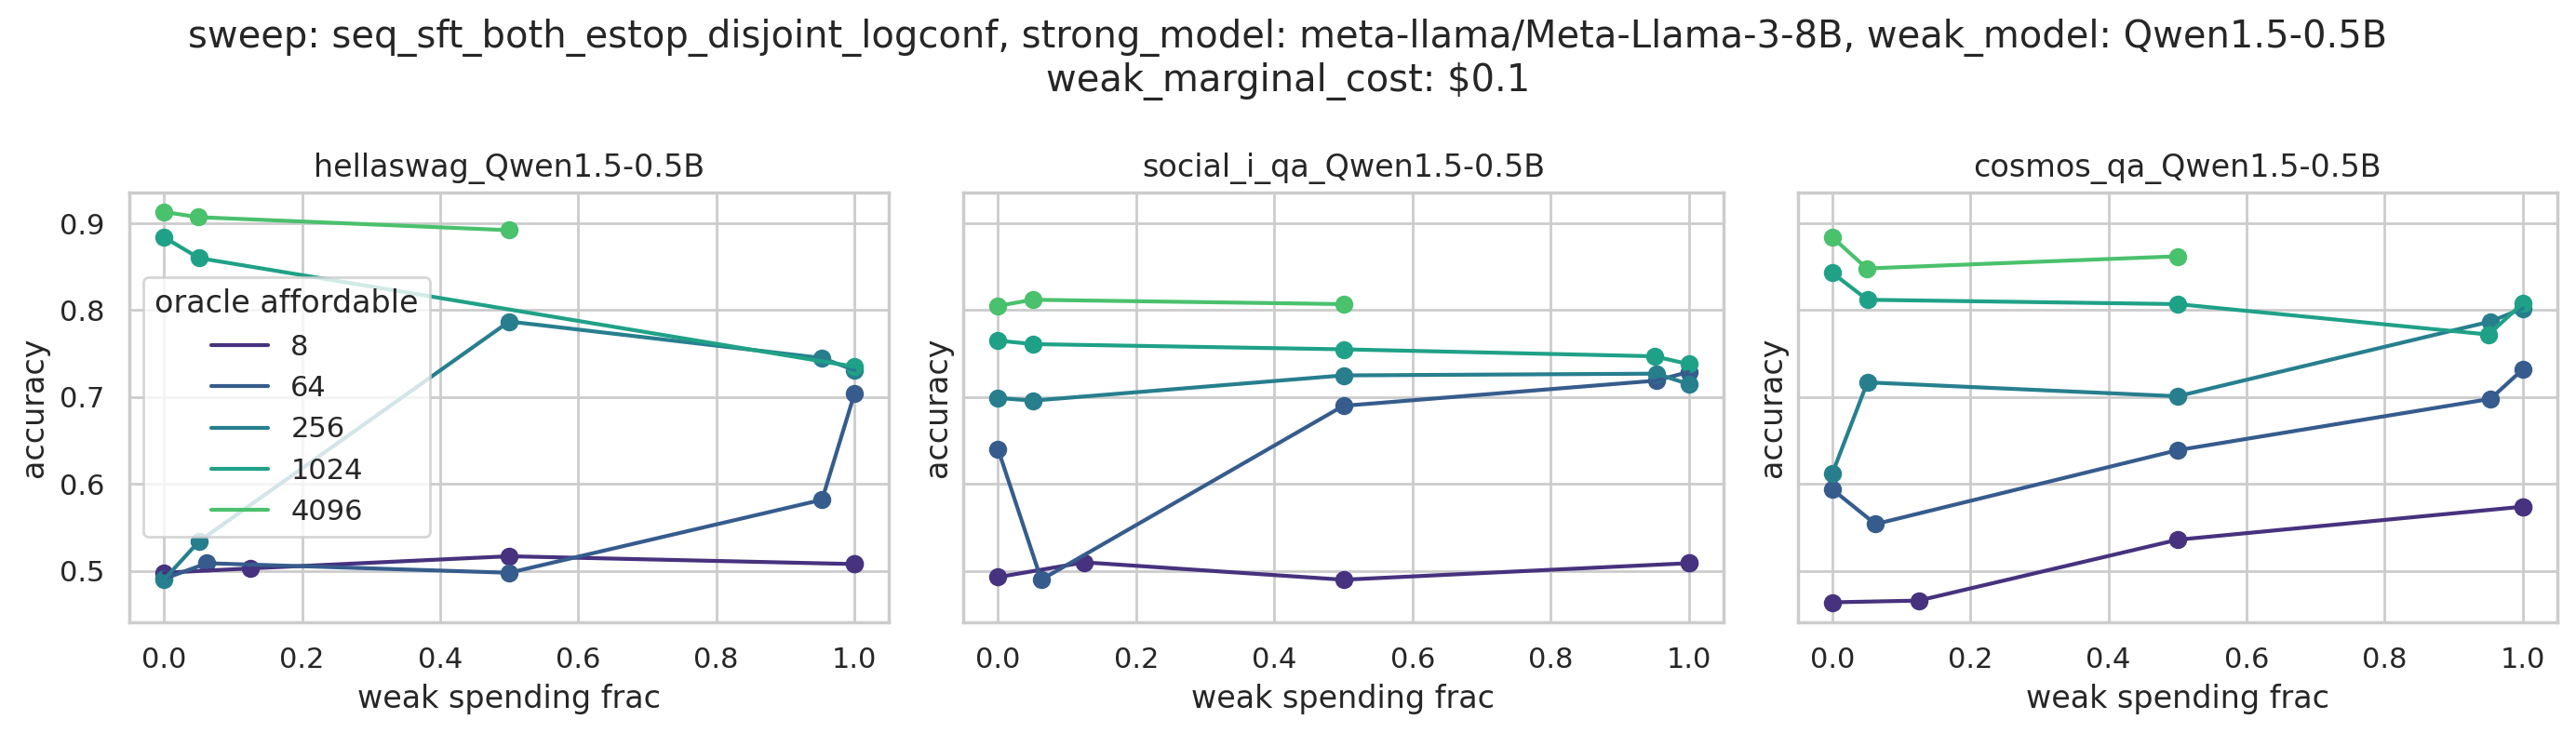

In [7]:
sns.set_theme(style="whitegrid")
sns.set_palette("viridis")

weak_marginal_cost = 1/10
weak_model = "Qwen1.5-0.5B"
strong_model = "meta-llama/Meta-Llama-3-8B"


sweep_name = "seq_sft_both_estop_disjoint_logconf"
# sweep_name = "seq_sft_both_estop_active_oracle_disjoint"
# sweep_name = "seq_sft_both_estop_clean_disjoint"
weak_spending_fracs = [0.0, 0.05, 0.5, 0.95, 1.0]
oracle_affordables = [8, 64, 256, 1024, 4096]
current_base_ds_names = ["hellaswag", "social_i_qa", "cosmos_qa"]

# sweep_name = "seq_sft_both_estop_clean_disjoint"
# weak_spending_fracs = [0.0, 0.05, 0.2, 0.4, 0.6, 0.8, 0.95, 1.0]
# oracle_affordables = [8, 16, 64, 256, 512, 1024, 4096, 8192]
# current_base_ds_names = base_ds_names

kinds = ["{base_name}_" + weak_model,]

fig, axs = plt.subplots(len(kinds), len(current_base_ds_names), figsize=(2 + 4 * len(current_base_ds_names), len(kinds) * 4), sharex=True, sharey=True, dpi=200)
axs = axs.reshape((-1, len(current_base_ds_names)))
for i, kind in enumerate(kinds):
    for j, base_ds_name in enumerate(current_base_ds_names):
        plt.sca(axs[i, j])
        ds_name = kind.format(base_name=base_ds_name)
        run_name = (ds_name,
            strong_model,
            sweep_name)
        
        # saliences = salience_df.loc[(ds_name, strong_model)]
        # salience_weak, salience_oracle = saliences["salience_weak"], saliences["salience_oracle"]
        
        for oracle_affordable in oracle_affordables:
            accs = []
            actual_wsfs = []
            for wsf in weak_spending_fracs:
                osf = 1 - wsf
                n_oracle = int(wsf * oracle_affordable)
                n_weak = int((oracle_affordable - n_oracle) / weak_marginal_cost)
                acc = find_result_by_n(results_df, n_weak, n_oracle, run_name, rtol=0.05, verbose=False)
                if acc is not None:
                    accs.append(acc)
                    actual_wsfs.append(1 - (n_oracle / (n_oracle + n_weak * weak_marginal_cost)))
                
            plt.plot(actual_wsfs, accs, label=f"{oracle_affordable}")
            plt.scatter(actual_wsfs, accs)
            
        plt.xlabel("weak spending frac")
        plt.ylabel("accuracy")
        plt.title(f"{ds_name}")
        if i == 0 and j == 0:
            plt.legend(title="oracle affordable")
plt.suptitle(f"sweep: {sweep_name}, strong_model: {strong_model}, weak_model: {weak_model}\nweak_marginal_cost: \\${weak_marginal_cost}")
plt.tight_layout()
plt.show()

# Results averaged over datasets and seeds

/tmp/ipykernel_717037/1670403316.py:75: PerformanceWarning: indexing past lexsort depth may impact performance.
  curr_df = results_df.loc[run_name]


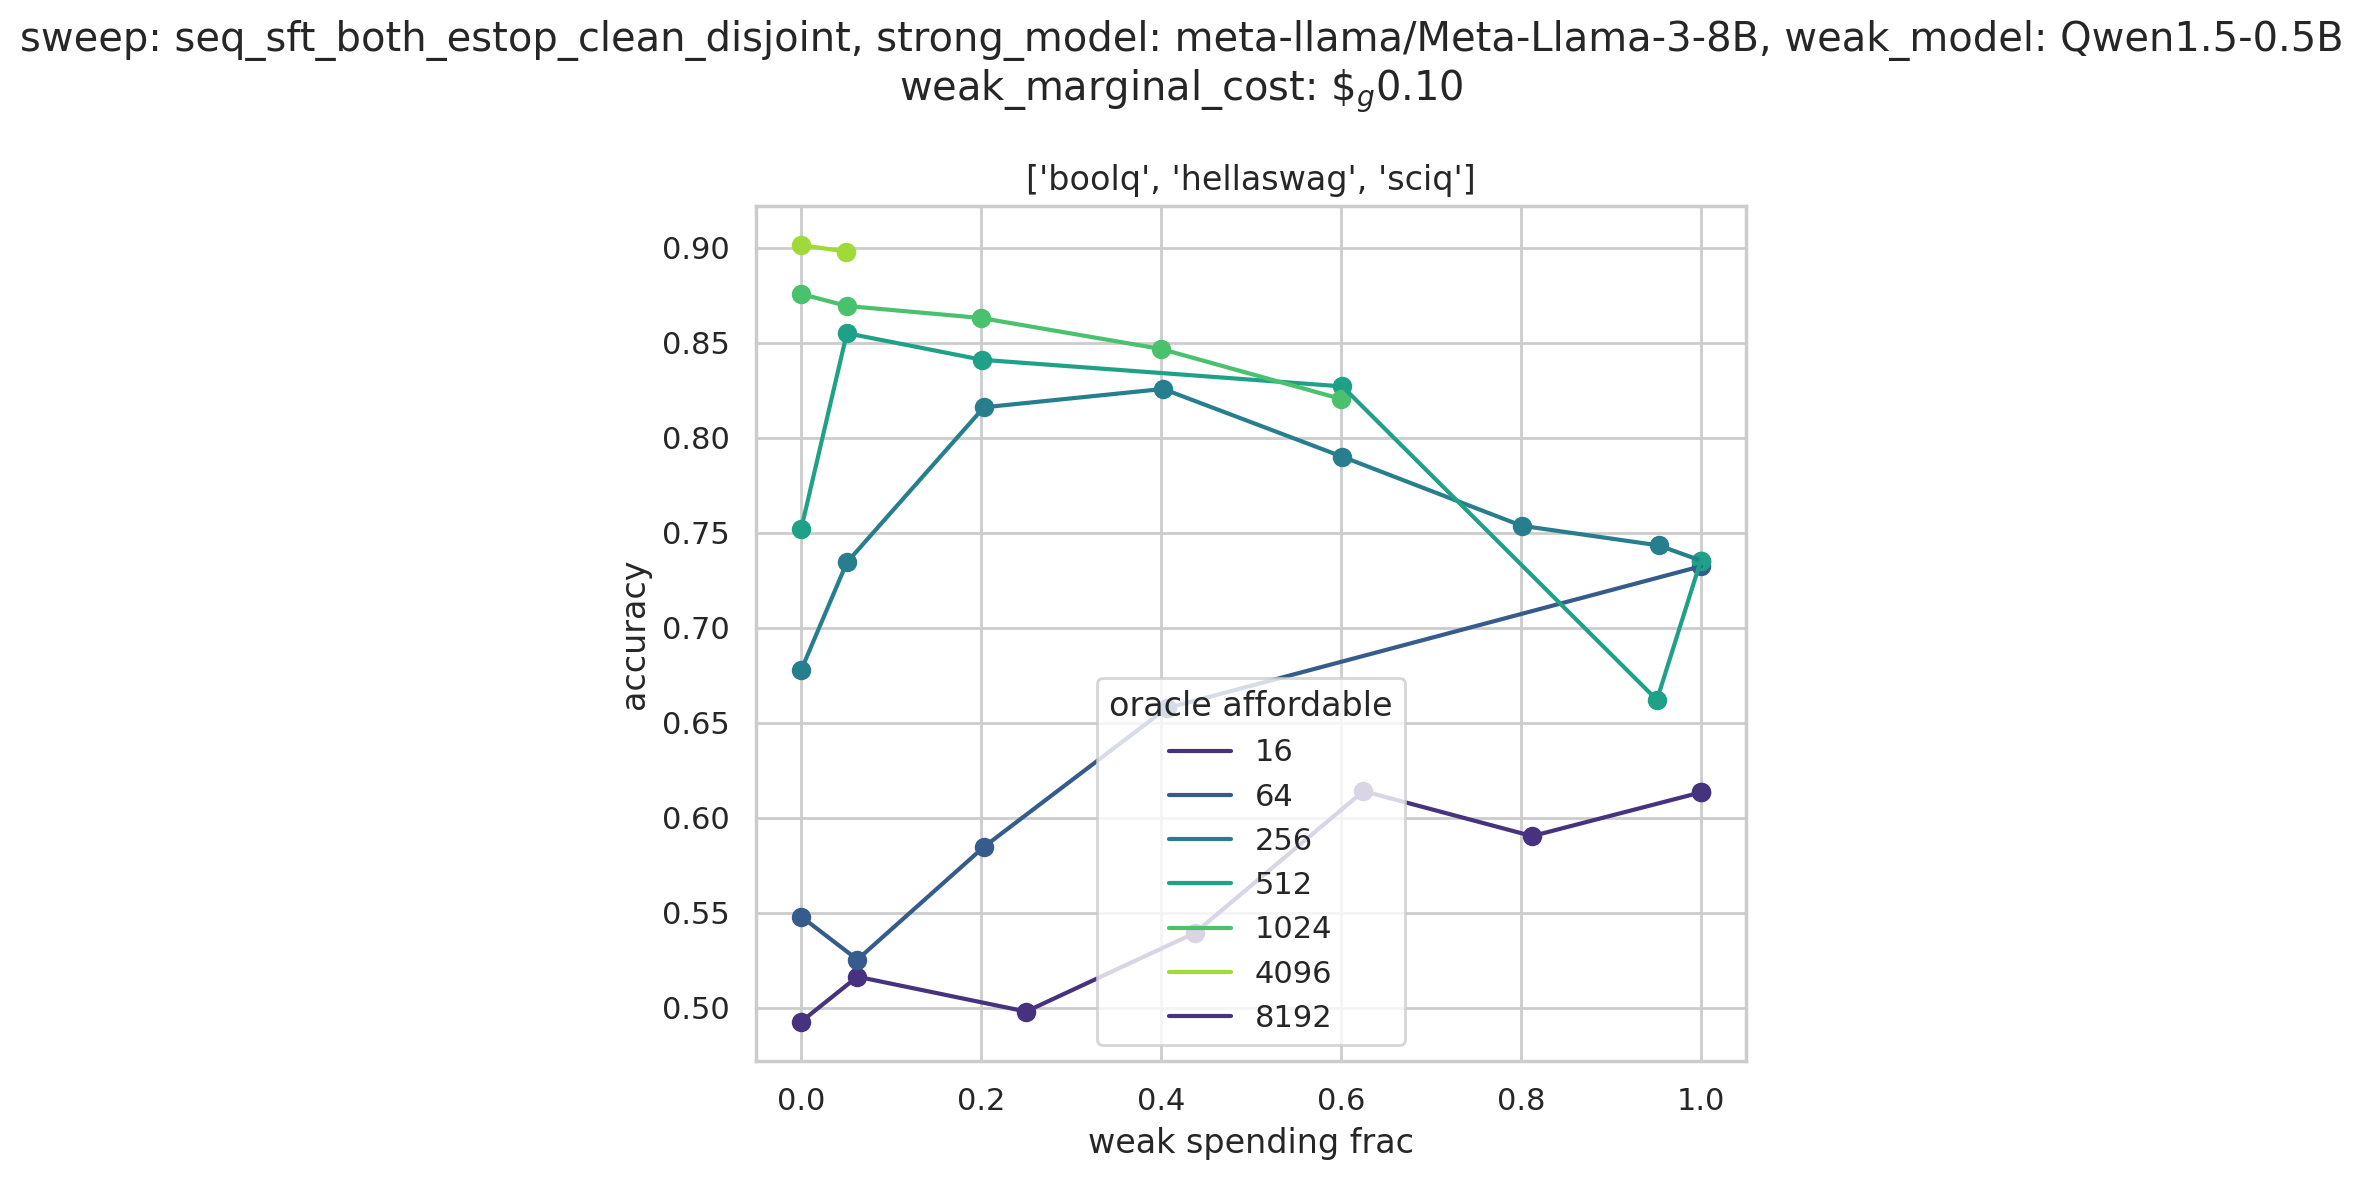

In [5]:
sns.set_theme(style="whitegrid")
sns.set_palette("viridis")

weak_marginal_cost = 1/10
weak_model = "Qwen1.5-0.5B"
strong_model = "meta-llama/Meta-Llama-3-8B"

sweep_name = "seq_sft_both_estop_clean_disjoint"
weak_spending_fracs = [0.0, 0.05, 0.2, 0.4, 0.6, 0.8, 0.95, 1.0]
oracle_affordables = [16, 64, 256, 512, 1024, 4096, 8192]
current_base_ds_names = base_ds_names[:3]  # TODO

kind = "{base_name}_" + weak_model

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=True, sharey=True, dpi=200)
plt.sca(ax)
# saliences = salience_df.loc[(ds_name, strong_model)]
# salience_weak, salience_oracle = saliences["salience_weak"], saliences["salience_oracle"]

for oracle_affordable in oracle_affordables:
    accs = []
    actual_wsfs = []
    for wsf in weak_spending_fracs:
        osf = 1 - wsf
        n_oracle = int(wsf * oracle_affordable)
        n_weak = int((oracle_affordable - n_oracle) / weak_marginal_cost)
        current_accs = []
        for j, base_ds_name in enumerate(current_base_ds_names):
            ds_name = kind.format(base_name=base_ds_name)
            run_name = (ds_name,
                strong_model,
                sweep_name)
            acc = find_result_by_n(results_df, n_weak, n_oracle, run_name, rtol=0.05, verbose=False)
            current_accs.append(acc)
        if any(ca is None for ca in current_accs):
            continue
        accs.append(np.mean(current_accs))
        actual_wsfs.append(1 - (n_oracle / (n_oracle + n_weak * weak_marginal_cost)))
        
    plt.plot(actual_wsfs, accs, label=f"{oracle_affordable}")
    plt.scatter(actual_wsfs, accs)
    
plt.xlabel("weak spending frac")
plt.ylabel("accuracy")
plt.title(current_base_ds_names)
plt.legend(title="oracle affordable")
plt.suptitle(f"sweep: {sweep_name}, strong_model: {strong_model}, weak_model: {weak_model}\nweak_marginal_cost: \\$$_g${weak_marginal_cost:.2f}")
plt.tight_layout()
plt.show()

# Few shot vs sft

In [6]:
results_df.xs("weak_prompted_oracle_sft_estop", level="sweep_name")

auroc    acc  \
ds_name                  model_name                                    
hellaswag_Qwen1.5-0.5B   meta-llama/Meta-Llama-3-8B  0.507368  0.510   
                         meta-llama/Meta-Llama-3-8B  0.489983  0.491   
                         meta-llama/Meta-Llama-3-8B  0.500318  0.491   
                         meta-llama/Meta-Llama-3-8B  0.511262  0.489   
                         meta-llama/Meta-Llama-3-8B  0.493832  0.517   
                         meta-llama/Meta-Llama-3-8B  0.972499  0.906   
                         meta-llama/Meta-Llama-3-8B  0.521505  0.493   
cosmos_qa_Qwen1.5-0.5B   meta-llama/Meta-Llama-3-8B  0.858020  0.778   
                         meta-llama/Meta-Llama-3-8B  0.535374  0.513   
                         meta-llama/Meta-Llama-3-8B  0.477827  0.493   
                         meta-llama/Meta-Llama-3-8B  0.952056  0.898   
                         meta-llama/Meta-Llama-3-8B  0.594306  0.557   
                         meta-llama/Meta-Llama-3-8B  0.460707  0.475   
                         meta-llama/Meta-Llama-3-8B  0.588082  0.487   
social_i_qa_Qwen1.5-0.5B meta-llama/Meta-Llama-3-8B  0.559408  0.490   
                         meta-llama/Meta-Llama-3-8B  0.511885  0.492   
                         meta-llama/Meta-Llama-3-8B  0.542493  0.490   
                         meta-llama/Meta-Llama-3-8B  0.917523  0.844   
                         meta-llama/Meta-Llama-3-8B  0.568820  0.536   
                         meta-llama/Meta-Llama-3-8B  0.502441  0.490   
                         meta-llama/Meta-Llama-3-8B  0.726783  0.679   
                         meta-llama/Meta-Llama-3-8B  0.488639  0.498   
                         meta-llama/Meta-Llama-3-8B  0.691529  0.642   

                                                                     model_name  \
ds_name                  model_name                                               
hellaswag_Qwen1.5-0.5B   meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
cosmos_qa_Qwen1.5-0.5B   meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
social_i_qa_Qwen1.5-0.5B meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   

                                                     num_oracle  num_weak  \
ds_name                  model_name                                         
hellaswag_Qwen1.5-0.5B   

In [7]:
results_df.xs("oracle_prompted_weak_sft_estop", level="sweep_name")

auroc    acc  \
ds_name                  model_name                                    
hellaswag_Qwen1.5-0.5B   meta-llama/Meta-Llama-3-8B  0.506576  0.509   
                         meta-llama/Meta-Llama-3-8B  0.545701  0.534   
                         meta-llama/Meta-Llama-3-8B  0.975892  0.915   
                         meta-llama/Meta-Llama-3-8B  0.477863  0.512   
                         meta-llama/Meta-Llama-3-8B  0.522413  0.507   
cosmos_qa_Qwen1.5-0.5B   meta-llama/Meta-Llama-3-8B  0.671190  0.624   
                         meta-llama/Meta-Llama-3-8B  0.571963  0.515   
                         meta-llama/Meta-Llama-3-8B  0.581257  0.513   
social_i_qa_Qwen1.5-0.5B meta-llama/Meta-Llama-3-8B  0.500188  0.501   

                                                                     model_name  \
ds_name                  model_name                                               
hellaswag_Qwen1.5-0.5B   meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
cosmos_qa_Qwen1.5-0.5B   meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
social_i_qa_Qwen1.5-0.5B meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   

                                                     num_oracle  num_weak  \
ds_name                  model_name                                         
hellaswag_Qwen1.5-0.5B   meta-llama/Meta-Llama-3-8B           8         0   
                         meta-llama/Meta-Llama-3-8B         256         0   
                         meta-llama/Meta-Llama-3-8B        8192         0   
                         meta-llama/Meta-Llama-3-8B          16         0   
                         meta-llama/Meta-Llama-3-8B          64         0   
cosmos_qa_Qwen1.5-0.5B   meta-llama/Meta-Llama-3-8B          64         0   
                         meta-llama/Meta-Llama-3-8B           8         0   
                         meta-llama/Meta-Llama-3-8B          16         0   
social_i_qa_Qwen1.5-0.5B meta-llama/Meta-Llama-3-8B          15        10   

                                                     num_oracle_nonunique  \
ds_name                  model_name                                         
hellaswag_Qwen1.5-0.5B   meta-llama/Meta-Llama-3-8B                     8   
                         meta-llama/Meta-Llama-3-8B                   256   
                         meta-llama/Meta-Llama-3-8B                  8192   
                         meta-llama/Meta-Llama-3-8B                    16   
                         meta-llama/Meta-Llama-3-8B                    64   
cosmos_qa_Qwen1.5-0.5B   meta-llama/Meta-Llama-3-8B                    64   
                         meta-llama/Meta-Llama-3-8B                     8   
                         meta-llama/Meta-Llama-3-8B                    16   
social_i_qa_Qwen1.5-0.5B meta-llama/Meta-Llama-3-8B                    15   

                                                     num_weak_nonunique  \
ds_name                  model_name                                       
hellaswag_Qwen1.5-0.5B   meta-llama/Meta-Llama-3-8B                   0   
                         meta-llama/Meta-Llama-3-8B                   0   
                         meta-llama/Meta-Llama-3-8B                   0   
                         meta-llama/Meta-Llama-3-8B                   0   
                         meta-llama/Meta-Llama-3-8B                   0   
cosmos_qa_Qwen1.5-0.5B   meta-llama/Meta-Llama-3-8B                   0   
                         meta-llama/Meta-Llama-3-8B  